In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {'AZ': {},
                     'IN': {},
                     'MA': {},
                     'TN': {},
                     'WA': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = False



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 5 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading azgeo2020.pl...
	reading ingeo2020.pl...
	reading mageo2020.pl...
	reading tngeo2020.pl...
	reading wageo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 1,246,539 geographies in 1 minutes 6 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.2 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 46 congressional districts to shapefiles in 11.5 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for AZ...
	getting shapefiles for IN...
	getting shapefiles for MA...
	getting shapefiles for TN...
	getting shapefiles for WA...


Joined 8,566 tracts to shapefiles in 14.6 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
#this_state = 'VA'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
#     if (this_state in thisrow['NAME']):
#         print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,1) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


#cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.9 seconds!


getting water areas...
	reading water file 0 of 255...
	reading water file 10 of 255...
	reading water file 20 of 255...
	reading water file 30 of 255...
	reading water file 40 of 255...
	reading water file 50 of 255...
	reading water file 60 of 255...
	reading water file 70 of 255...
	reading water file 80 of 255...
	reading water file 90 of 255...
	reading water file 100 of 255...
	reading water file 110 of 255...
	reading water file 120 of 255...
	reading water file 130 of 255...
	reading water file 140 of 255...
	reading water file 150 of 255...
	reading water file 160 of 255...
	reading water file 170 of 255...
	reading water file 180 of 255...
	reading water file 190 of 255...
	reading water file 200 of 255...
	reading water file 210 of 255...
	reading water file 220 of 255...
	reading water file 230 of 255...
	reading water file 240 of 255...
	reading water file 250 of 255...
Got 2,007 water

In [14]:

# print('getting CBSAs (metro areas)...')
# cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
# cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
# cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
# cbsa_gdf = cbsa_gdf.set_index('GEOID')

# print('Finding populations of CBSAs...')
# cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
# for ix, thisrow in cbsa_gdf.iterrows():
#     if ('ID' in thisrow['NAME']):
#         print('\t{0:}...'.format(thisrow['NAME']))
#     cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
# cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan



# cbsa_gdf[(cbsa_gdf['NAME'].apply(lambda x: 'ID' in x)) & (cbsa_gdf['POP100'].isnull())]
# tract_gdf['COUNTYNS']

In [15]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting WA...
		Plotting TN...
		Plotting IN...
		Plotting MA...
		Plotting AZ...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 49 seconds!


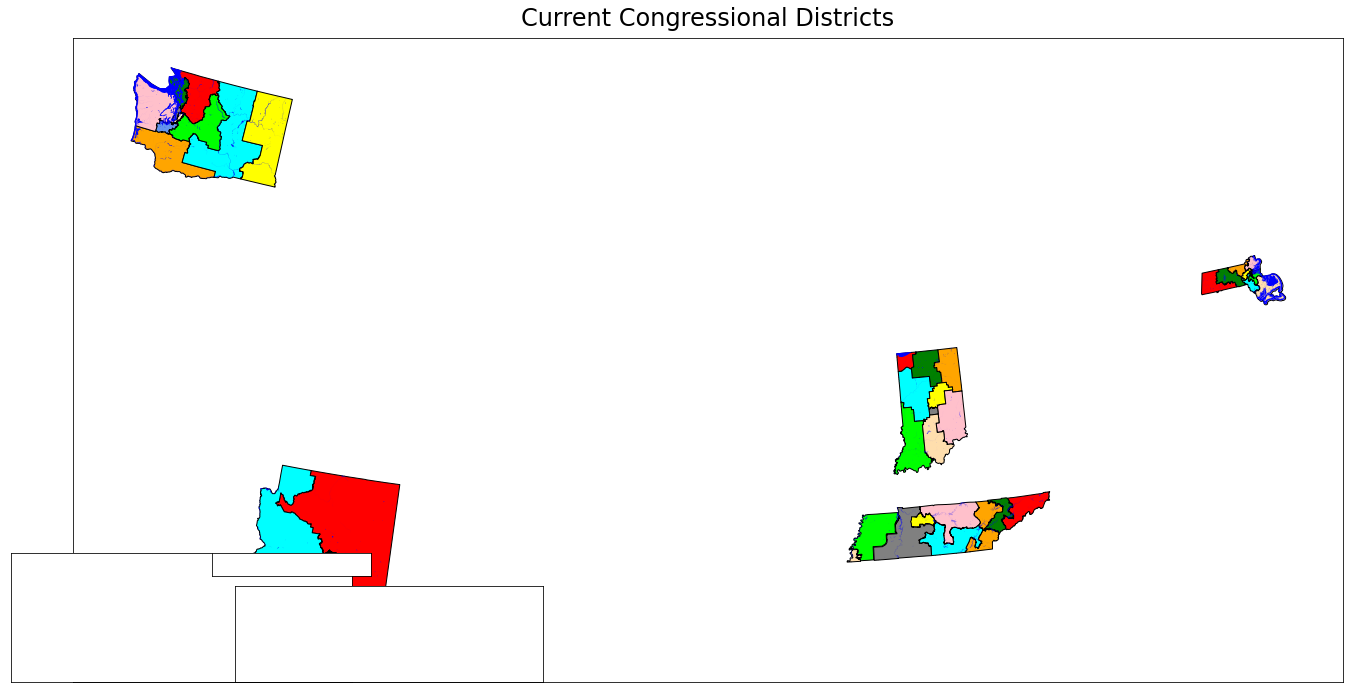

In [16]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [17]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'AZ': {'STATEFP': 4,
  'seats_old': 9,
  'seats_new': 9,
  'target': 794611.3333333334},
 'IN': {'STATEFP': 18,
  'seats_old': 9,
  'seats_new': 9,
  'target': 753947.5555555555},
 'MA': {'STATEFP': 25,
  'seats_old': 9,
  'seats_new': 9,
  'target': 781101.8888888889},
 'TN': {'STATEFP': 47,
  'seats_old': 9,
  'seats_new': 9,
  'target': 767871.1111111111},
 'WA': {'STATEFP': 53, 'seats_old': 10, 'seats_new': 10, 'target': 770528.1}}

# ARIZONA

In [18]:
s = time.time()
this_state = 'AZ'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Santa Cruz County',3], 
    ['Cochise County',3], 
    ['Graham County',3], 
    ['Greenlee County',3],
    ['Yuma County',3], 
    ['La Paz County',3],     
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Paradise Valley',6], 

['Glendale',8],
    ['Sun City',8],
#    ['Tolleson',8], 
    ['Avondale',8], 
    ['Youngtown',8], 
    ['Litchfield Park',8], 
    ['Sun City West',8], 
    ['El Mirage',8], 
    ['Surprise',8],

    
['Chandler',7],
    ['Guadalupe',7],
    ['Sun Lakes',7],
    ['Goodyear Village',7],
    ['Gilbert',7], 
    ['Queen Creek',7],    
    ['Tolleson',7], 
#    ['Avondale',7],  
#    ['Litchfield Park',7], 

    
['Tempe',5], 
    ['Mesa',5], 
    ['Fountain Hills',5],    


['Carefree',4],
    ['Cave Creek',4],
    ['Apache Junction',4], 
    ['San Tan Valley',4], 
    ['Florence',4], 
    ['Coolidge',4],
    ['Ak-Chin Village',4],
    ['Casa Grande',4],
    ['Maricopa',4], 
    ['Gold Canyon',4], 
    
 
    
['Tucson',2],
    ['South Tucson',2],
    ['Sahuarita',2], 
    ['Green Valley',2], 
    ['Corona de Tucson',2], 
    ['Vail',2], 
    ['Drexel Heights',2], 
    ['Valencia West',2], 
    ['Tucson Estates',2], 
    ['Three Points',2], 
    ['Summit',2],
    ['Tanque Verde',2],
    ['Catalina Foothills',2],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

#tract_gdf.loc[['1400000US04013050604'], 'new_district'] = 7        # SE corner of Goodyear
#tract_gdf.loc[['1400000US04013723304', '1400000US04013723306'], 'new_district'] = 7     # Rural SW of Phoneix


print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US04013106400', '1400000US04013106501','1400000US04013106502','1400000US04013106600'], 'new_district'] = 9
tract_gdf.loc[['1400000US04013106703','1400000US04013106802','1400000US04013107101', '1400000US04013107102','1400000US04013107201','1400000US04013107202', '1400000US04013107300','1400000US04013107401','1400000US04013107402'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013107403','1400000US04013107404','1400000US04013107500', '1400000US04013107601','1400000US04013107602','1400000US04013107700', '1400000US04013107800','1400000US04013107900','1400000US04013108100'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013108200','1400000US04013108301','1400000US04013108302', '1400000US04013108400','1400000US04013108501','1400000US04013108502', '1400000US04013108601','1400000US04013108602','1400000US04013108802'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013108901','1400000US04013108902','1400000US04013109001', '1400000US04013109002','1400000US04013109003','1400000US04013109101', '1400000US04013109102','1400000US04013109200','1400000US04013109300'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013109401','1400000US04013109402','1400000US04013109500', '1400000US04013109602','1400000US04013109603','1400000US04013109604', '1400000US04013109703','1400000US04013109706','1400000US04013109707'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013109801','1400000US04013109802','1400000US04013109900', '1400000US04013110001','1400000US04013110002','1400000US04013110100', '1400000US04013110400','1400000US04013110501','1400000US04013110502'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013110600','1400000US04013110701','1400000US04013110702', '1400000US04013110801','1400000US04013110802','1400000US04013110901', '1400000US04013110902','1400000US04013111000','1400000US04013111100'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013111201','1400000US04013111202','1400000US04013111203', '1400000US04013111204','1400000US04013111300','1400000US04013111401', '1400000US04013111402','1400000US04013111501','1400000US04013111502'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013111601','1400000US04013111602','1400000US04013111700', '1400000US04013111800','1400000US04013111900','1400000US04013112100', '1400000US04013112201','1400000US04013112202','1400000US04013112301'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013112302','1400000US04013112401','1400000US04013112402', '1400000US04013112502','1400000US04013112504','1400000US04013112507', '1400000US04013112508','1400000US04013112512','1400000US04013112514'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013112515','1400000US04013112516','1400000US04013112519', '1400000US04013112520','1400000US04013112521','1400000US04013112522', '1400000US04013112601','1400000US04013112602','1400000US04013112700'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013112900','1400000US04013113000','1400000US04013113100', '1400000US04013113201','1400000US04013113202','1400000US04013113204', '1400000US04013113301','1400000US04013113502','1400000US04013113503'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013113601','1400000US04013113602','1400000US04013113701', '1400000US04013113702','1400000US04013113800','1400000US04013113900', '1400000US04013114000','1400000US04013114100','1400000US04013114200'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013114301','1400000US04013114302','1400000US04013114401', '1400000US04013114402','1400000US04013114500','1400000US04013114600', '1400000US04013114704','1400000US04013114705','1400000US04013114800'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013114900','1400000US04013115200','1400000US04013115300','1400000US04013115400','1400000US04013115500','1400000US04013115600', '1400000US04013115700','1400000US04013115801','1400000US04013115802'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013115900','1400000US04013116000','1400000US04013116100', '1400000US04013116202','1400000US04013116203','1400000US04013116204', '1400000US04013116300','1400000US04013116400','1400000US04013116500'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013116605','1400000US04013116606','1400000US04013116607', '1400000US04013116610','1400000US04013116612','1400000US04013116614', '1400000US04013116615','1400000US04013116616','1400000US04013116617'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013116621','1400000US04013116736','1400000US04013116800', '1400000US04013116900','1400000US04013117000','1400000US04013117100', '1400000US04013117200','1400000US04013117300'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013108000', '1400000US04013981000', '1400000US04013217400'], 'new_district'] = 9      # Downtown Phoenix
tract_gdf.loc[['1400000US04013082007', '1400000US04013082008', '1400000US04013082009', '1400000US04013082010', '1400000US04013082018', '1400000US04013082028', '1400000US04013082205'], 'new_district'] = 9      # West of Downtown Phoenix 
tract_gdf.loc[['1400000US04013109601', '1400000US04013109702', '1400000US04013109704', '1400000US04013109705', '1400000US04013112510', '1400000US04013112517', '1400000US04013112518', '1400000US04013112523', '1400000US04013112524', '1400000US04013116620'], 'new_district'] = 9      # West of Downtown Phoenix 
tract_gdf.loc[['1400000US04013105800','1400000US04013105900'], 'new_district'] = 9        # North of Downtown Phoenix
tract_gdf.loc[['1400000US04013106701','1400000US04013106702','1400000US04013106801'], 'new_district'] = 9        # North of Downtown Phoenix
tract_gdf.loc[['1400000US04013106900','1400000US04013107001','1400000US04013107002'], 'new_district'] = 9        # North of Downtown Phoenix



tract_gdf.loc[['1400000US04013104702', '1400000US04013105101','1400000US04013105102','1400000US04013105103', '1400000US04013105200','1400000US04013105300','1400000US04013105400'], 'new_district'] = 6        # North of Downtown Phoenix
tract_gdf.loc[['1400000US04013105501','1400000US04013105502','1400000US04013105503', '1400000US04013105601','1400000US04013105602','1400000US04013105701', '1400000US04013105702','1400000US04013106001','1400000US04013106002'], 'new_district'] = 6        # North of Downtown Phoenix
tract_gdf.loc[['1400000US04013106003','1400000US04013106100','1400000US04013106200', '1400000US04013106300'], 'new_district'] = 6        # North of Downtown Phoenix
tract_gdf.loc[['1400000US04013103205','1400000US04013103206','1400000US04013103207', '1400000US04013103208','1400000US04013103209','1400000US04013103210'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013103211','1400000US04013103212','1400000US04013103214', '1400000US04013103215','1400000US04013103216','1400000US04013103217', '1400000US04013103220','1400000US04013103302','1400000US04013103303'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013103304','1400000US04013103305','1400000US04013103306', '1400000US04013103400','1400000US04013103501','1400000US04013103502', '1400000US04013103604','1400000US04013103605','1400000US04013103606'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013103607','1400000US04013103608','1400000US04013103609', '1400000US04013103611','1400000US04013103612','1400000US04013103614', '1400000US04013103615','1400000US04013103701','1400000US04013103702'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013103900','1400000US04013104000','1400000US04013104100', '1400000US04013104202','1400000US04013104203','1400000US04013104204', '1400000US04013104205','1400000US04013104206','1400000US04013104207'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013104212', '1400000US04013104218','1400000US04013104219', '1400000US04013104225','1400000US04013104226'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013104301','1400000US04013104302','1400000US04013104401', '1400000US04013104402','1400000US04013104501','1400000US04013104502', '1400000US04013104600','1400000US04013104701','1400000US04013104801'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013104802','1400000US04013104900', '1400000US04013614400','1400000US04013614601', '1400000US04013614602'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013616100','1400000US04013616200', '1400000US04013616300','1400000US04013616400','1400000US04013616500', '1400000US04013616600','1400000US04013616700','1400000US04013616800', '1400000US04013616900','1400000US04013617001','1400000US04013617002'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013617100','1400000US04013617200','1400000US04013617300', '1400000US04013618100','1400000US04013618200', '1400000US04013618300','1400000US04013618400','1400000US04013618500'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013618600','1400000US04013618700','1400000US04013618800', '1400000US04013618900','1400000US04013619000','1400000US04013619100', '1400000US04013619200','1400000US04013619300','1400000US04013619400'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013619500','1400000US04013619601','1400000US04013619602', '1400000US04013619700','1400000US04013619800',], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013614700','1400000US04013614800','1400000US04013614900', '1400000US04013615001','1400000US04013615002','1400000US04013615100', '1400000US04013615201','1400000US04013615202','1400000US04013619900'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013611300', '1400000US04013611400', '1400000US04013611500', '1400000US04013612000', '1400000US04013612200', '1400000US04013612301', '1400000US04013612302', '1400000US04013612401', '1400000US04013612402'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013611800', '1400000US04013611900', '1400000US04013613300', '1400000US04013614300', '1400000US04013614500'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013610600', '1400000US04013611600', '1400000US04013611700', '1400000US04013612500', '1400000US04013612700', '1400000US04013612900'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013612600', '1400000US04013612800'], 'new_district'] = 6       # Northern part of Phoenix
tract_gdf.loc[['1400000US04013614000', '1400000US04013614100', '1400000US04013614200', '1400000US04013615700', '1400000US04013615800', '1400000US04013615900', '1400000US04013616000', '1400000US04013617700', '1400000US04013617800', '1400000US04013617900', '1400000US04013618000', '1400000US04013071511'], 'new_district'] = 6       # Between Phoenix and Glendale
tract_gdf.loc[['1400000US04013104214', '1400000US04013104215', '1400000US04013104216', '1400000US04013104217', '1400000US04013104221', '1400000US04013104222', '1400000US04013104223', '1400000US04013104224', '1400000US04013104227', '1400000US04013092305', '1400000US04013092306', '1400000US04013092307', '1400000US04013092308', '1400000US04013092311', '1400000US04013092312'], 'new_district'] = 6       # Between Phoenix and Glendale
tract_gdf.loc[['1400000US04013092309', '1400000US04013092401', '1400000US04013092402', '1400000US04013092500', '1400000US04013092600'], 'new_district'] = 6       # Between Phoenix and Glendale            
tract_gdf.loc[['1400000US04013103219'], 'new_district'] = 6       # E Phoneix, by border with Mesa           




tract_gdf.loc[['1400000US04013071509','1400000US04013071510', '1400000US04013071512','1400000US04013071513','1400000US04013071514', '1400000US04013071515','1400000US04013071516','1400000US04013071517'], 'new_district'] = 8    # Around Glendale
tract_gdf.loc[['1400000US04013071903','1400000US04013071906','1400000US04013071909', '1400000US04013071910','1400000US04013071911','1400000US04013071912', '1400000US04013071913','1400000US04013071914','1400000US04013071915'], 'new_district'] = 8    # Around Glendale
tract_gdf.loc[['1400000US04013082016','1400000US04013092708','1400000US04013092709', '1400000US04013092724','1400000US04013093200','1400000US04013610901', '1400000US04013610902','1400000US04013611200','1400000US04013613400'], 'new_district'] = 8    # Around Glendale
tract_gdf.loc[['1400000US04013613500','1400000US04013613601','1400000US04013613602', '1400000US04013613700','1400000US04013613800','1400000US04013613900', '1400000US04013615300','1400000US04013615500','1400000US04013615600'], 'new_district'] = 8    # Around Glendale
tract_gdf.loc[['1400000US04013617600'], 'new_district'] = 8    # Around Glendale
tract_gdf.loc[['1400000US04013061011','1400000US04013061013','1400000US04013061018', '1400000US04013061020','1400000US04013061024','1400000US04013061044', '1400000US04013061045','1400000US04013061046','1400000US04013061047'], 'new_district'] = 8
tract_gdf.loc[['1400000US04013061048','1400000US04013061049','1400000US04013061050', '1400000US04013061051','1400000US04013061052','1400000US04013061053', '1400000US04013061054','1400000US04013061055'], 'new_district'] = 8
tract_gdf.loc[['1400000US04013061063','1400000US04013061064','1400000US04013061300', '1400000US04013082002','1400000US04013082012','1400000US04013082017'], 'new_district'] = 8
tract_gdf.loc[['1400000US04013092719', '1400000US04013092723'], 'new_district'] = 8
tract_gdf.loc[['1400000US04013061017', '1400000US04013061056', '1400000US04013061057'], 'new_district'] = 8     # W of Litchfield Park


tract_gdf.loc[['1400000US04013050611'], 'new_district'] = 8    # Goodyear / Buckeye
tract_gdf.loc[['1400000US04013061058'], 'new_district'] = 8    # Between Tolleson and Goodyear
tract_gdf.loc[['1400000US04013723307', '1400000US04013723309', '1400000US04013723310', '1400000US04013723311', '1400000US04013980900'], 'new_district'] = 8     # S part of Goodyear
tract_gdf.loc[['1400000US04013050612', '1400000US04013050613'], 'new_district'] = 8    # Buckeye



tract_gdf.loc[['1400000US04013116205','1400000US04013116611','1400000US04013116618', '1400000US04013116619','1400000US04013116703','1400000US04013116707', '1400000US04013116708','1400000US04013116709','1400000US04013116710'], 'new_district'] = 7     # S city of Phoneix
tract_gdf.loc[['1400000US04013116711','1400000US04013116712','1400000US04013116713', '1400000US04013116714','1400000US04013116715','1400000US04013116717', '1400000US04013116718','1400000US04013116719','1400000US04013116720'], 'new_district'] = 7     # S city of Phoneix
tract_gdf.loc[['1400000US04013116721','1400000US04013116725','1400000US04013116727', '1400000US04013116728','1400000US04013116729','1400000US04013116730', '1400000US04013116731','1400000US04013116732','1400000US04013116733'], 'new_district'] = 7     # S city of Phoneix
tract_gdf.loc[['1400000US04013116734','1400000US04013116735','1400000US04013116737', '1400000US04013116738'], 'new_district'] = 7     # S city of Phoneix
tract_gdf.loc[['1400000US04013941000', '1400000US04013941100'], 'new_district'] = 7     # Rural SW of Phoneix

tract_gdf.loc[['1400000US04013816502'], 'new_district'] = 7     # Between Gilbert and Queen Creek



tract_gdf.loc[['1400000US04013082204','1400000US04013082206','1400000US04013082207', '1400000US04013082212','1400000US04013082213'], 'new_district'] = 7   # Between Tolleson  and Phoneix






tract_gdf.loc[['1400000US04013420202', '1400000US04013420209', '1400000US04013420214'], 'new_district'] = 5    # Hole in east-central Mesa
tract_gdf.loc[['1400000US04013422639'], 'new_district'] = 5    # Hole in S Mesa
tract_gdf.loc[['1400000US04013420111', '1400000US04013420114', '1400000US04013420115', '1400000US04013422627', '1400000US04013422628', '1400000US04013422629', '1400000US04013422630', '1400000US04013422632'], 'new_district'] = 5    # Hole in E Mesa
tract_gdf.loc[['1400000US04013420108', '1400000US04013420110', '1400000US04013420116', '1400000US04013422653'], 'new_district'] = 5    # E border of Mesa
tract_gdf.loc[['1400000US04013941300'], 'new_district'] = 5    # SE of Scottsdale, N of Mesa
tract_gdf.loc[['1400000US04013218100', '1400000US04013218200', '1400000US04013218300'], 'new_district'] = 5    # S end of Scottsdale
tract_gdf.loc[['1400000US04013217400'], 'new_district'] = 5
tract_gdf.loc[['1400000US04013217800', '1400000US04013217900', '1400000US04013218000'], 'new_district'] = 5    # S end of Scottsdale





tract_gdf.loc[['1400000US04013216806','1400000US04013216807','1400000US04013216809', '1400000US04013216810','1400000US04013216813','1400000US04013216816', '1400000US04013216822','1400000US04013216826','1400000US04013216829'], 'new_district'] = 4      # Rest of Scottsdale
tract_gdf.loc[['1400000US04013216830','1400000US04013216831','1400000US04013216832', '1400000US04013216833','1400000US04013216834','1400000US04013216835', '1400000US04013216836','1400000US04013216837','1400000US04013216838'], 'new_district'] = 4      # Rest of Scottsdale
tract_gdf.loc[['1400000US04013216839','1400000US04013216840','1400000US04013216841', '1400000US04013216842','1400000US04013216843','1400000US04013216844', '1400000US04013216845','1400000US04013216849','1400000US04013216850'], 'new_district'] = 4      # Rest of Scottsdale
tract_gdf.loc[['1400000US04013216851','1400000US04013216852','1400000US04013216853', '1400000US04013216854','1400000US04013216855','1400000US04013216858', '1400000US04013216859','1400000US04013216860','1400000US04013216861'], 'new_district'] = 4      # Rest of Scottsdale
tract_gdf.loc[['1400000US04013216901','1400000US04013216902','1400000US04013217001', '1400000US04013217002','1400000US04013217101','1400000US04013217102', '1400000US04013217201','1400000US04013217203','1400000US04013217204'], 'new_district'] = 4      # Rest of Scottsdale
tract_gdf.loc[['1400000US04013217300','1400000US04013217501','1400000US04013217502', '1400000US04013217600','1400000US04013217700','1400000US04013613000', '1400000US04013613100','1400000US04013613200','1400000US04013980700'], 'new_district'] = 4      # Rest of Scottsdale





###### Rest of Maricopa County is District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Maricopa County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 4


tract_gdf.loc[['1400000US04021000217'], 'new_district'] = 4    # S and E of Apache Junction / Gold Canyon
tract_gdf.loc[['1400000US04021000201', '1400000US04021000307', '1400000US04021000311', '1400000US04021000319'], 'new_district'] = 4    # N Pinal County
tract_gdf.loc[['1400000US04021941200', '1400000US04021941300', '1400000US04021001200', '1400000US04021001303', '1400000US04021001600'], 'new_district'] = 4    # N and W of Arizona City
tract_gdf.loc[['1400000US04021000204', '1400000US04021000805'], 'new_district'] = 4    # Holes in N Pinal County

###### Rest of Pinal County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Pinal County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 3




tract_gdf.loc[['1400000US04019004112', '1400000US04019004114', '1400000US04019004115', '1400000US04019004127', '1400000US04019004129', '1400000US04019004133', '1400000US04019004026', '1400000US04019004081', '1400000US04019004422', '1400000US04019004412', '1400000US04019004433'], 'new_district'] = 2
tract_gdf.loc[['1400000US04019004325', '1400000US04019004327', '1400000US04019004328', '1400000US04019004340', '1400000US04019004324'], 'new_district'] = 2    # Sahuarita / Green Valley
tract_gdf.loc[['1400000US04019004434'], 'new_district'] = 2    # Tucson Estates
tract_gdf.loc[['1400000US04019940900', '1400000US04019941000'], 'new_district'] = 2    # Between Tucson and Sahuarita
tract_gdf.loc[['1400000US04019004109'], 'new_district'] = 2    # Far SE Pima County



###### Rest of Pima County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Pima County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 3



tract_gdf.loc[['1400000US04007000800', '1400000US04007001000', '1400000US04007001300', '1400000US04007940400'], 'new_district'] = 3    # S Gila County
tract_gdf.loc[['1400000US04007000700', '1400000US04007000900', '1400000US04007001100', '1400000US04007001200', '1400000US04007940200'], 'new_district'] = 3    # S Gila County


               
    
    
## print('All the rest are district 1...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 1


# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')



getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 156...
	Tracts intersecting (but not within) District 2: 64...
		Examining tract 1 of 64...
		Examining tract 51 of 64...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
	Tracts within District 4: 38...
	Tracts intersecting (but not within) District 4: 65...
		Examining tract 1 of 65...
		Examining tract 51 of 65...
Looking for tracts related to places in District 5...
	Tracts within District 5: 141...
	Tracts intersecting (but not within) District 5: 85...
		Examining tract 1 of 85...
		Examining tract 51 of 85...
Looking for tracts related to places in District 6...
	Tracts within District 6: 1...
	Tracts intersecting (but not within) District 6: 16...
		Examining tract 1 of 16...
Looking for tracts relate

# INDIANA

In [19]:
s = time.time()
this_state = 'IN'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Lake County',1], 
    ['Porter County',1], 
    
    
['Allen County',3],
    ['Whitley County',3],
    ['Noble County',3],
    ['DeKalb County',3],
    ['LaGrange County',3],
    ['Steuben County',3],
    ['Wells County',3],
    ['Adams County',3],
    ['Jay County',3],
    ['Blackford County',3],    
    ['Huntington County',3],

    
['St. Joseph County',2],
    ['Elkhart County',2],
    ['Starke County',2],
    ['Marshall County',2],
    ['Kosciusko County',2],
    ['Fulton County',2],
    
    
    
['Clark County',9],
    ['Floyd County',9],
    ['Harrison County',9],
    ['Dearborn County',9],
    ['Franklin County',9],
    ['Ohio County',9],
    ['Union County',9],
    ['Ripley County',9],
    ['Switzerland County',9],
    ['Jefferson County',9],
    ['Scott County',9],
    ['Jennings County',9],
    ['Fayette County',9],
    ['Randolph County',9],
    ['Wayne County',9],
    ['Decatur County',9],
    ['Henry County',9],
    ['Rush County',9],
    
    
['Warrick County',8],
    ['Vanderburgh County',8],
    ['Posey County',8],
    ['Spencer County',8],
    ['Dubois County',8],
    ['Pike County',8],
    ['Gibson County',8],
    ['Perry County',8],
    ['Crawford County',8],
    ['Orange County',8],
    ['Washington County',8],
    ['Lawrence County',8],
    ['Bartholomew County',8],
    ['Jackson County',8],
    ['Brown County',8],
    
    
['Tipton County',5],
    ['Howard County',5],
    ['Madison County',5], 
    ['Grant County',5],     
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Beech Grove',7], 
    ['Speedway',7], 
    ['Southport',7], 
    ['Williams Creek',7], 
    ['Meridian Hills',7], 
    ['Rocky Ripple',7], 
    ['Spring Hill',7], 

['Plainfield',6], 
    ['Avon',6], 
    ['Brownsburg',6], 
    ['Zionsville',6], 
    ['Carmel',6], 
    ['Fishers',6], 
    ['McCordsville',6], 
    ['Greenwood',6], 

['Michigan City',1],
    
['Logansport',2],
    
['Muncie',9],
    ['Yorktown',9],
    
['Bloomington',8],
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i


print('Assigning districts by tract number...')


tract_gdf.loc[['1400000US18097321900','1400000US18097322000','1400000US18097322100', '1400000US18097322200','1400000US18097322300','1400000US18097322400', '1400000US18097322500','1400000US18097322601','1400000US18097322602'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097322700','1400000US18097330805','1400000US18097330900', '1400000US18097331000','1400000US18097341200','1400000US18097341600', '1400000US18097342600','1400000US18097350100','1400000US18097350300'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097350400','1400000US18097350500','1400000US18097350600', '1400000US18097350700','1400000US18097350800','1400000US18097350900', '1400000US18097351000','1400000US18097351200','1400000US18097351500'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097351600','1400000US18097351700','1400000US18097351900', '1400000US18097352100','1400000US18097352300','1400000US18097352400', '1400000US18097352500','1400000US18097352600','1400000US18097352700'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097352800','1400000US18097353300','1400000US18097353500', '1400000US18097353600','1400000US18097354201','1400000US18097354202', '1400000US18097354400','1400000US18097354500','1400000US18097354700'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097354800','1400000US18097354900','1400000US18097355000', '1400000US18097355100','1400000US18097355300','1400000US18097355400', '1400000US18097355500','1400000US18097355600','1400000US18097355700'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097355900','1400000US18097356200','1400000US18097356400', '1400000US18097356900','1400000US18097357000','1400000US18097357100', '1400000US18097357200','1400000US18097357300','1400000US18097357400'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097357601','1400000US18097357602','1400000US18097357800', '1400000US18097357900','1400000US18097358000','1400000US18097358100', '1400000US18097360101','1400000US18097360102','1400000US18097360201'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097360302','1400000US18097360602','1400000US18097360700', '1400000US18097360800','1400000US18097360900','1400000US18097361000', '1400000US18097361100','1400000US18097361200','1400000US18097361402'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097380200','1400000US18097380301','1400000US18097380302', '1400000US18097380501','1400000US18097380502','1400000US18097380600', '1400000US18097380800','1400000US18097390103','1400000US18097390408'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097390411','1400000US18097390500','1400000US18097390700', '1400000US18097390900','1400000US18097391001','1400000US18097391002'], 'new_district'] = 7     # Downtown Indianapolis
tract_gdf.loc[['1400000US18097310105','1400000US18097310106','1400000US18097310110', '1400000US18097310111','1400000US18097310201', '1400000US18097310203','1400000US18097310204','1400000US18097310305'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097310306','1400000US18097310308','1400000US18097310309', '1400000US18097310310','1400000US18097310311','1400000US18097310312', '1400000US18097320108','1400000US18097320109','1400000US18097320202'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097320301','1400000US18097320305','1400000US18097320400', '1400000US18097320500','1400000US18097320600','1400000US18097320700', '1400000US18097320901','1400000US18097320902','1400000US18097320903'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097321001','1400000US18097321002','1400000US18097321100', '1400000US18097321200','1400000US18097321300','1400000US18097321400', '1400000US18097321600','1400000US18097321700','1400000US18097321800'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097330401','1400000US18097330500', '1400000US18097340102','1400000US18097340108','1400000US18097340111', '1400000US18097340112','1400000US18097340115','1400000US18097340201'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097340301','1400000US18097340302','1400000US18097340400', '1400000US18097340500','1400000US18097340600','1400000US18097340700', '1400000US18097340901','1400000US18097340903','1400000US18097341100'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097341701','1400000US18097341702','1400000US18097341902', '1400000US18097341903','1400000US18097341904', '1400000US18097342101','1400000US18097342200','1400000US18097342300'], 'new_district'] = 7     # NW Indianapolis
tract_gdf.loc[['1400000US18097342400','1400000US18097342500','1400000US18097390601'], 'new_district'] = 7
tract_gdf.loc[['1400000US18097380101','1400000US18097380102','1400000US18097380700', '1400000US18097380901','1400000US18097380902','1400000US18097381002'], 'new_district'] = 7       # S Indianapolis
tract_gdf.loc[['1400000US18097381004','1400000US18097381101','1400000US18097381102', '1400000US18097381203','1400000US18097381204','1400000US18097381205', '1400000US18097381206','1400000US18097381207','1400000US18097390104'], 'new_district'] = 7       # S Indianapolis
tract_gdf.loc[['1400000US18097390405','1400000US18097390406','1400000US18097390407', '1400000US18097390409','1400000US18097390410'], 'new_district'] = 7       # S Indianapolis
tract_gdf.loc[['1400000US18097320306', '1400000US18097361300', '1400000US18097361401'], 'new_district'] = 7       # E Indianapolis
tract_gdf.loc[['1400000US18097330806', '1400000US18097360202', '1400000US18097360301', '1400000US18097360601'], 'new_district'] = 7       # E Indianapolis
tract_gdf.loc[['1400000US18097370201', '1400000US18097370203', '1400000US18097370204', '1400000US18097370305', '1400000US18097370306', '1400000US18097380103'], 'new_district'] = 7       # SW Indianapolis

    
####### The rest of Marion County is District 6
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Marion County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 6

tract_gdf.loc[['1400000US18081610101', '1400000US18081610102', '1400000US18081610603', '1400000US18081610607', '1400000US18081610608', '1400000US18081610703', '1400000US18081610704'], 'new_district'] = 6       # N Johnson County (just S of Indianapolis)
tract_gdf.loc[['1400000US18109510101', '1400000US18109510102', '1400000US18109510201', '1400000US18109510300'], 'new_district'] = 6       # SW exurbs of Indianapolis
tract_gdf.loc[['1400000US18063210103', '1400000US18063210105', '1400000US18063210106', '1400000US18063210107', '1400000US18063210108', '1400000US18063210701', '1400000US18063210610', '1400000US18063210617', '1400000US18063210612'], 'new_district'] = 6       # W suburbs of Indianapolis
tract_gdf.loc[['1400000US18145710200', '1400000US18059410201', '1400000US18059410801', '1400000US18059410802', '1400000US18059411000', '1400000US18059410901', '1400000US18059410902'], 'new_district'] = 6       # E of Indianapolis





# Most of the rest of Indianapolis Metro area is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Marion County', 'Hamilton County', 'Johnson County', 'Hancock County', 'Morgan County', 'Shelby County', 'Boone County', 'Hendricks County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5
### (more of District 5 below)



tract_gdf.loc[['1400000US18091041500', '1400000US18091040600', '1400000US18091041100', '1400000US18091041200', '1400000US18091041400', '1400000US18091041600', '1400000US18091990000'], 'new_district'] = 1       # Michigan City area
tract_gdf.loc[['1400000US18073100400', '1400000US18073100800', '1400000US18073100901', '1400000US18073100902', '1400000US18073101000'], 'new_district'] = 1       # N Jasper County
tract_gdf.loc[['1400000US18111100400', '1400000US18111100500'], 'new_district'] = 1       # N Newton County




tract_gdf.loc[['1400000US18103952000', '1400000US18103952100'], 'new_district'] = 2       # N Miami County
tract_gdf.loc[['1400000US18017950900', '1400000US18017951000', '1400000US18017951700', '1400000US18017951100'], 'new_district'] = 2       # N Cass County


####### The rest of LaPorte County is District 2
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'LaPorte County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 2



####### The rest of Wabash County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Wabash County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

tract_gdf.loc[['1400000US18035002700'], 'new_district'] = 3    # NE Delaware County




tract_gdf.loc[['1400000US18035001700', '1400000US18035002100', '1400000US18035002201', '1400000US18035002202', '1400000US18035002301', '1400000US18035002302', '1400000US18035002604'], 'new_district'] = 9    # S Delaware County



####### The rest of Delaware and Miami Counties is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Delaware County', 'Miami County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5

tract_gdf.loc[['1400000US18017951800', '1400000US18017951900'], 'new_district'] = 5     # S Cass County




tract_gdf.loc[['1400000US18105000501', '1400000US18105000502', '1400000US18105000802', '1400000US18105001002', '1400000US18105001102', '1400000US18105001103', '1400000US18105001501', '1400000US18105001502', '1400000US18105001403'], 'new_district'] = 8     # SE Bloomington County



# print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4


# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

# print(state_target)    
for i in range(1, these_states_dict[this_state]['seats_new']+1): 
    if (tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() > 0):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(
            i, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum(), 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum()/state_target, 
            tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['new_district'] == i)]['POP100'].sum() - state_target))        
print('Done!')


getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
	Tracts within District 1: 7...
	Tracts intersecting (but not within) District 1: 7...
		Examining tract 1 of 7...
Looking for tracts related to places in District 2...
	Tracts intersecting (but not within) District 2: 9...
		Examining tract 1 of 9...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
Looking for tracts related to places in District 6...
	Tracts within District 6: 25...
	Tracts intersecting (but not within) District 6: 96...
		Examining tract 1 of 96...
		Examining tract 51 of 96...
Looking for tracts related to places in District 7...
	Tracts within District 7: 4...
	Tracts intersecting (but not within) District 7: 37...
		Examining tract 1 of 37...
Looking for tracts related to places in District 8...
	Tracts within Di

# MASSACHUSETTS

In [20]:
s = time.time()
this_state = 'MA'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Dukes County',9], 
    ['Nantucket County',9], 
    ['Barnstable County',9],
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Boston',7], 
    ['Brookline',7], 
    ['Chelsea',7], 

    
['Winthrop Town',5], 
    ['Everett',5], 
    ['Somerville',5], 
    ['Cambridge',5], 
    ['Newton',5], 
    ['Watertown Town',5], 
    ['Revere',5], 
    ['Needham',5], 
    ['Dedham',5], 
    ['Milton',5], 
    ['Quincy',5], 
    ['Malden',5], 
    ['Medford',5], 
    
    
['Melrose',6], 
    ['Stoneham',6],
    ['Lynn',6],
    ['Saugus',6],
    ['Nahant',6],
    ['Swampscott',6],
    ['Marblehead',6],
    ['Salem',6],
    ['Beverly',6],
    ['Danvers',6],
    ['Peabody',6],
    ['Lynnfield',6],
    ['Wakefield',6],
    ['Reading',6],
    ['Winchester',6],
    ['Belmont',6],
    ['Woburn',6],
    ['Lexington',6],
    ['Burlington',6],
    ['Arlington',6],
    ['Waltham',6],    
    ['Pinehurst',6],
    ['Hanscom AFB',6],
    ['Wilmington',6],
    
    
    
['Weymouth Town',8], 
    ['Braintree Town',8], 
    ['Holbrook',8], 
    ['Randolph Town',8], 
    ['Hull',8],
    ['Hingham',8],
    ['Brockton',8], 
    ['Abington',8], 
    ['Taunton',8], 
    ['Raynham Center',8], 
    ['Bridgewater Town',8], 
    ['Scituate',8],  
    ['Marshfield Hills',8],  
    ['Marshfield',8],  
    ['Ocean Bluff-Brant Rock',8],  
    ['Green Harbor',8],  
    ['Cedar Crest',8],     
    ['Attleboro',8], 
    ['North Attleborough Town',8],    

    
['Fall River',9], 
    ['New Bedford',9], 
    ['Somerset',9], 
        
    
['Lowell',3],
    ['West Concord',3], 
    ['Hanscom AFB',3], 

    
['Fitchburg',4], 
    ['Lunenburg',4], 
    ['Leominster',4], 
    ['Devens',4],
    ['Shirley',4],

    
['Ware',2], 
    ['Holland',2],
    ['Palmer Town',2],
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i


print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US25025980101', '1400000US25025990101'], 'new_district'] = 5   # Boston Harbor Islands
tract_gdf.loc[['1400000US25021412300', '1400000US25021415300'], 'new_district'] = 5    # S of Dedham/Milton


tract_gdf.loc[['1400000US25017330101', '1400000US25017330102', '1400000US25017330201', '1400000US25017330202'], 'new_district'] = 6    # N Middlesex County (E of Wilmington)
tract_gdf.loc[['1400000US25009212101', '1400000US25009212102', '1400000US25009216100'], 'new_district'] = 6    # SW Essex County


tract_gdf.loc[['1400000US25005600100','1400000US25005600202','1400000US25005600203', '1400000US25005600204','1400000US25005611101','1400000US25005611102', '1400000US25005611201','1400000US25005612100','1400000US25005612202'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25005985600','1400000US25021415201','1400000US25021456101','1400000US25021456102', '1400000US25021456200','1400000US25021456301','1400000US25021456302'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25021456401','1400000US25021456402','1400000US25021457100', '1400000US25023501101','1400000US25023501102','1400000US25023501201', '1400000US25023501203','1400000US25023501204','1400000US25023502101'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25023502102','1400000US25023502200','1400000US25023503101', '1400000US25023503102','1400000US25023504101','1400000US25023504102', '1400000US25023505102','1400000US25023505103','1400000US25023508101'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25023508102','1400000US25023521101','1400000US25023521102', '1400000US25023521201','1400000US25023521202','1400000US25023522101', '1400000US25023522102','1400000US25023523100','1400000US25023523201'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25023523203','1400000US25023523204','1400000US25023524101', '1400000US25023524102','1400000US25023540101','1400000US25023542200','1400000US25023542301'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25023542302'], 'new_district'] = 8       # N Plymouth County
tract_gdf.loc[['1400000US25023505104', '1400000US25023505201', '1400000US25023506102', '1400000US25023506103', '1400000US25023508200', '1400000US25023507101', '1400000US25023507104', '1400000US25023507103'], 'new_district'] = 8     # NE Plymouth County
tract_gdf.loc[['1400000US25021423101'], 'new_district'] = 8     # Island in Norfolk County
tract_gdf.loc[['1400000US25021423102'], 'new_district'] = 8     # Outer coast of Norfolk County
tract_gdf.loc[['1400000US25005610100', '1400000US25005610202', '1400000US25005610203', '1400000US25005610204', '1400000US25005611202'], 'new_district'] = 8     # N Bristol County
               

### The rest of Plymouth County is District 9
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Plymouth County'])) & (tract_gdf['new_district']).isnull(),  'new_district'] = 9

tract_gdf.loc[['1400000US25005615100','1400000US25005616100','1400000US25005617101', '1400000US25005617102','1400000US25005632100','1400000US25005632200', '1400000US25005633100','1400000US25005633200','1400000US25005645101'], 'new_district'] = 9      # S Bristol County
tract_gdf.loc[['1400000US25005645102','1400000US25005645103','1400000US25005646101', '1400000US25005646103','1400000US25005646104','1400000US25005653101', '1400000US25005653102','1400000US25005653203','1400000US25005653204'], 'new_district'] = 9      # S Bristol County
tract_gdf.loc[['1400000US25005653301','1400000US25005653304','1400000US25005654100', '1400000US25005654200','1400000US25005655100','1400000US25005655200', '1400000US25005655300','1400000US25005655400','1400000US25005985500'], 'new_district'] = 9      # S Bristol County
tract_gdf.loc[['1400000US25005990000'], 'new_district'] = 9      # S Bristol County



### The rest of Norfolk County is District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Norfolk County'])) & (tract_gdf['new_district']).isnull(),  'new_district'] = 4



### The rest of Essex County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Essex County'])) & (tract_gdf['new_district']).isnull(),  'new_district'] = 3

tract_gdf.loc[['1400000US25017313101','1400000US25017313102','1400000US25017314101', '1400000US25017314102','1400000US25017314200','1400000US25017314301', '1400000US25017314302','1400000US25017315100','1400000US25017315200'], 'new_district'] = 3      # Lowell area
tract_gdf.loc[['1400000US25017315401','1400000US25017315402','1400000US25017315403', '1400000US25017315500','1400000US25017316101','1400000US25017316102', '1400000US25017316300','1400000US25017316400','1400000US25017316500'], 'new_district'] = 3      # Lowell area
tract_gdf.loc[['1400000US25017317101','1400000US25017317102','1400000US25017317103', '1400000US25017317201','1400000US25017317202','1400000US25017317203', '1400000US25017317301','1400000US25017317302','1400000US25017318100'], 'new_district'] = 3      # Lowell area
tract_gdf.loc[['1400000US25017318200','1400000US25017318300','1400000US25017318400'], 'new_district'] = 3      # Lowell area
tract_gdf.loc[['1400000US25017362100', '1400000US25017328100', '1400000US25017359100', '1400000US25017359303'], 'new_district'] = 3      # Lowell area
tract_gdf.loc[['1400000US25017363105', '1400000US25017363106', '1400000US25017361100', '1400000US25017361300', '1400000US25017359301', '1400000US25017359302', '1400000US25017360300'], 'new_district'] = 3      # Central Middlesex County (south of Lowell)


## The rest of Middlesex County is District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Middlesex County'])) & (tract_gdf['new_district']).isnull(),  'new_district'] = 4

tract_gdf.loc[['1400000US25027712101', '1400000US25027712102', '1400000US25027761401', '1400000US25027761402', '1400000US25027713100', '1400000US25027715100'], 'new_district'] = 4      #  N Worcester County (near Leominster)
tract_gdf.loc[['1400000US25027741101', '1400000US25027741102'], 'new_district'] = 4      #  E Worcester County


## The rest of Worcester County is District 2
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Worcester County'])) & (tract_gdf['new_district']).isnull(),  'new_district'] = 2

tract_gdf.loc[['1400000US25015820101'], 'new_district'] = 2      #  Far E Hampshire County
tract_gdf.loc[['1400000US25013813701', '1400000US25013813702', '1400000US25013813801', '1400000US25013813802'], 'new_district'] = 2      #  Far E Hampden County
tract_gdf.loc[['1400000US25011040501', '1400000US25011040502'], 'new_district'] = 2      #  NE Franklin County


## print('All the rest are district 1...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 1


# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')


nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

e = time.time()
g += (e-s)


# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')



getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 3...
	Tracts intersecting (but not within) District 2: 12...
		Examining tract 1 of 12...
Looking for tracts related to places in District 3...
	Tracts within District 3: 26...
	Tracts intersecting (but not within) District 3: 21...
		Examining tract 1 of 21...
Looking for tracts related to places in District 4...
	Tracts within District 4: 21...
	Tracts intersecting (but not within) District 4: 12...
		Examining tract 1 of 12...
Looking for tracts related to places in District 5...
	Tracts within District 5: 182...
	Tracts intersecting (but not within) District 5: 89...
		Examining tract 1 of 89...
		Examining tract 51 of 89...
Looking for tracts related to places in District 6...
	Tracts within District 6: 156...
	Tracts intersecting (but not within) District 6: 26

# TENNESSEE

In [21]:
s = time.time()
this_state = 'TN'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Davidson County',5],  
    
    
['Rutherford County',6], 
    ['Wilson County',6],


['Cheatham County',7],  
    ['Cannon County',7],
    ['Dickson County',7],
    ['Hickman County',7],
    ['Macon County',7],
    ['Maury County',7],
    ['Robertson County',7],
    ['Smith County',7],
    ['Trousdale County',7],
    ['DeKalb County',7],
    
    
    
['Knox County',2],
    ['Blount County',2],
    ['Anderson County',2],
    ['Loudon County',2],

    
    
['Hamilton County',3],
    ['Marion County',3],
    ['Sequatchie County',3],
    ['Bradley County',3],
    ['Polk County',3],
    ['McMinn County',3],
    ['Monroe County',3],
    ['Rhea County',3],
    ['Meigs County',3],
    ['Bledsoe County',3],
    ['Roane County',3],
    ['Jasper County',3],
    

    
['Johnson County',1],
    ['Carter County',1], 
    ['Sullivan County',1], 
    ['Washington County',1], 
    ['Greene County',1], 
    ['Hawkins County',1], 
    ['Hamblen County',1], 
    ['Cocke County',1], 
    ['Unicoi County',1], 
    ['Jefferson County',1], 
    ['Sevier County',1],


    
    
['Tipton County',8],
    ['Fayette County',8],
    ['Lauderdale County',8],
    ['Hardeman County',8],
    ['Haywood County',8],
    ['Madison County',8],
    ['Crockett County',8],
    ['Dyer County',8],
    ['Gibson County',8],
    ['Lake County',8],
    ['Obion County',8],
    ['Weakley County',8],
    ['Henry County',8],
    ['Stewart County',8],
    ['Houston County',8],
    ['Humphreys County',8],
    ['Benton County',8],
    ['Carroll County',8],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Brentwood',5], 

    
['Memphis',9], 
    ['Germantown',9], 
    ['Bartlett',9], 
    
    
['Shelbyville',7],
    ['Lewisburg',7],
    ['Clarksville',7],
    
    
['Lexington',8],
    ['Henderson',8],
    
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

#print('\n')
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('St. Anthony (Minneapolis area)', '1600000US2756680'))
#place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'St. Anthony') & (place_mapper_gdf.index != '1600000US2756680')].index, axis=0)
#print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i


print('Assigning districts by tract number...')





tract_gdf.loc[['1400000US47187050403', '1400000US47187050404', '1400000US47187050406'], 'new_district'] = 5   # W of Brentwood


tract_gdf.loc[['1400000US47187050104', '1400000US47187050212'], 'new_district'] = 6  # Brentwood but not really

### Rest of Williamson County is District 6
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Williamson County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 6

tract_gdf.loc[['1400000US47165021103','1400000US47165021104','1400000US47165021105', '1400000US47165021106','1400000US47165021107','1400000US47165021201', '1400000US47165021203','1400000US47165021204','1400000US47165021205'], 'new_district'] = 6      # Sumner County riverbend
tract_gdf.loc[['1400000US47165020603', '1400000US47165020901'], 'new_district'] = 6      # SE Sumner County
tract_gdf.loc[['1400000US47165021002', '1400000US47165021007', '1400000US47165021008', '1400000US47165021009'], 'new_district'] = 6      # South central Sumner County


### Rest of Sumner County is District 7
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Sumner County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 7


tract_gdf.loc[['1400000US47157021124', '1400000US47157980300'], 'new_district'] = 9      # Holes in Memphis
tract_gdf.loc[['1400000US47157020531'], 'new_district'] = 9      # Between Memphis and Bartlett
tract_gdf.loc[['1400000US47157021745', '1400000US47157021753', '1400000US47157021754'], 'new_district'] = 9      # Between Memphis and Germantown



### Rest of Shelby County is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Shelby County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8


tract_gdf.loc[['1400000US47145030100', '1400000US47145030203', '1400000US47145030205', '1400000US47145030206', '1400000US47145030802', '1400000US47145030900', '1400000US47145980100'], 'new_district'] = 2    # E Roane County


tract_gdf.loc[['1400000US47117955000', '1400000US47117955100', '1400000US47117955200'], 'new_district'] = 7      # N MarshalL County
tract_gdf.loc[['1400000US47003950100', '1400000US47003950201', '1400000US47003950202', '1400000US47003950300', '1400000US47003950401', '1400000US47003950402', '1400000US47003950600', '1400000US47003950700'], 'new_district'] = 7      # N and W Bedford County
#tract_gdf.loc[['1400000US47031970202', '', '1400000US47031970201'], 'new_district'] = 7      # N Coffee County
tract_gdf.loc[['1400000US47031970300', '1400000US47031970401'], 'new_district'] = 7 # N Coffee County

tract_gdf.loc[['1400000US47125101803', '1400000US47125101805', '1400000US47125101806', '1400000US47125101807', '1400000US47125101904', '1400000US47125102010'], 'new_district'] = 7      # E Montgomery County
tract_gdf.loc[['1400000US47125101202'], 'new_district'] = 7     # Western part of Clarksville


tract_gdf.loc[['1400000US47061955200', '1400000US47061955300', '1400000US47061955100'], 'new_district'] = 3     # S Grundy County
tract_gdf.loc[['1400000US47051960600', '1400000US47051960700', '1400000US47051960800'], 'new_district'] = 3     # S Franklin County
tract_gdf.loc[['1400000US47103975500', '1400000US47103975601', '1400000US47103975602'], 'new_district'] = 3     # S Lincoln County


### Rest of Montgomery County is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Montgomery County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

tract_gdf.loc[['1400000US47023970101', '1400000US47023970302', '1400000US47023970301'], 'new_district'] = 8     # NW Chester County (Henderson area)


# print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4



# print('Except ocean tracts...')
# tract_gdf.loc[(tract_gdf['STUSAB'] == this_state) & tract_gdf.index.map(lambda x: x[-6:] == '990000'), 'new_district'] = np.nan


e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

e = time.time()
g += (e-s)


# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')




getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
Looking for tracts related to places in District 2...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
	Tracts within District 5: 9...
	Tracts intersecting (but not within) District 5: 8...
		Examining tract 1 of 8...
Looking for tracts related to places in District 6...
Looking for tracts related to places in District 7...
	Tracts within District 7: 27...
	Tracts intersecting (but not within) District 7: 26...
		Examining tract 1 of 26...
Looking for tracts related to places in District 8...
	Tracts intersecting (but not within) District 8: 7...
		Examining tract 1 of 7...
Looking for tracts related to places in District 9...
	Tracts within District 9: 187...
	Tracts intersecting (but not within) District 9: 43...
		Examining tract 1 

# WASHSINGTON

In [22]:
s = time.time()

this_state = 'WA'
examine_duplicates = False

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[    
['Whatcom County',1],  
    ['Skagit County',1],  
    ['Island County',1],  
    ['San Juan County',1],  
    
    
['Clallam County',6],
    ['Jefferson County',6],
    ['Mason County',6],
    ['Kitsap County',6],

    
['Wahkiakum County',3],
    ['Cowlitz County',3],
    ['Clark County',3],
    ['Skamania County',3],
    ['Klickitat County',3],

    
['Spokane County',5],
    ['Pend Oreille County',5], 
    ['Stevens County',5], 
    ['Asotin County',5], 
    ['Whitman County',5], 
    ['Garfield County',5], 
    ['Columbia County',5],
    ['Walla Walla County',5],
    ['Ferry County',5],
    ['Lincoln County',5],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['Seattle',9], 
    ['White Center',9], 
    ['Boulevard Park',9], 
    ['Bryn Mawr-Skyway',9], 


    
['Burien',7], 
    ['Tukwila',7], 
    ['SeaTac',7],
    ['Kenmore',7], 
    ['Normandy Park',7], 
    ['Des Moines',7], 
    ['Kent',7], 
    ['Renton',7], 
    ['Kirkland',7], 
    ['Yarrow Point',7],
    ['Newcastle',7], 
    ['Bellevue',7], 
    ['Mercer Island',7], 
    ['Hunts Point',7], 
    ['Medina',7],
    ['Beaux Arts Village',7], 
    ['Clyde Hill',7], 
    ['Redmond',7],

    
    
['Snoqualmie',8], 
    ['North Bend',8],
    ['Issaquah',8], 
    ['East Renton Highlands',8], 
    ['Maple Heights-Lake Desire',8], 
    ['Shadow Lake',8], 
    ['Covington',8], 
    ['Maple Valley',8],
    
    

['Shoreline',2], 
    ['Lake Forest Park',2], 
    ['Sammamish',2], 
    ['Union Hill-Novelty Hill',2], 
    ['Cottage Lake',2], 
    ['Woodinville',2], 
    ['Bothell',2],
    ['High Bridge',2],
    ['Maltby',2],
    ['Bothell East',2], 
    ['Bothell West',2], 
    ['Cathcart',2], 
    ['Clearview',2], 
    ['Silver Firs',2], 
    ['Mill Creek East',2],
    ['Alderwood Manor',2], 
    ['Brier',2], 
    ['Lynnwood',2], 
    ['Mountlake Terrace',2], 
    ['Esperance',2], 
    ['Edmonds',2], 
    ['Woodway',2],
    ['Martha Lake',2], 
    ['Mill Creek',2], 
    ['Larch Way',2], 
    ['North Lynnwood',2], 
    ['Meadowdale',2], 
    ['Picnic Point',2], 
     ['Lake Stickney',2], 
     ['Mukilteo',2],
    ['Everett',2], 
    ['Eastmont',2],
    ['Fobes Hill',2], 
    

    
['Vashon',10],
    ['Lake Tapps',10], 
    ['Sumner',10], 
    ['Edgewood',10],
    ['Milton',10],
    ['Fife Heights',10],
    ['Bonney Lake',10],
    ['Fife',10],
    ['Alderton',10],
    
    ['Waller',10], 
    ['Summit',10], 
    ['Midland',10],
    ['Puyallup',10], 
    ['North Puyallup',10],
    ['Tacoma',10],
    ['South Creek',10], 
    ['Parkland',10], 
    ['Fircrest',10],
    ['University Place',10], 
    ['Lakewood',10],
 
    
['Chelan Falls',1],
    
    
['Wollochet',6], 
    ['Gig Harbor',6], 
    ['Artondale',6],   
    ['Olympia',6], 
    ['Tumwater',6], 
    ['Tanglewilde',6],
    ['Lacey',6],

    
    
['Raymond',8],
    ['South Bend',8],
    ['Chehalis',8], 
    ['Centralia',8], 
    ['Fords Prairie',8],
    
    
['Summitview',3], 
    ['Ahtanum',3],     
], columns=['NAME', 'new_district_by_place'])


print('Assigning districts by county...')


tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']

print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


this_state_places = place_gdf[(place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])]

if (len(this_state_places[
    (this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist())) 
    & (this_state_places['NAME'].duplicated() == True)]) > 0):
    print('DANGER: list of selected places includes duplicate place names:')
    print('\n')
    duplicated_name_list = this_state_places[(this_state_places['NAME'].isin(place_mapper_gdf['NAME'].tolist()))  & (this_state_places['NAME'].duplicated() == True)]['NAME'].tolist()
    for this_duplicated_name in duplicated_name_list:
        print('----- {0:} -----'.format(this_duplicated_name))
        if (examine_duplicates):
            all_duplicated_tracts_to_show = []
            for ix, thisrow in this_state_places[(this_state_places['NAME'] == this_duplicated_name)].iterrows():
                print('\t{0:} (GEOID = {1:})...'.format(thisrow['NAMELSAD'], ix))
                included_tracts = []
                for jx, thatrow in county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf.geometry.intersects(thisrow.geometry))].iterrows():
                    print('\t\tfinding tracts within {0:} County...'.format(thatrow['NAME']))
                    for kx, otherrow in tract_gdf[(tract_gdf['STUSAB'] == this_state) & (tract_gdf['COUNTY_NAME'] == '{0:} County'.format(thatrow['NAME']))].iterrows():
                        this_tract_total_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).area
                        this_tract_intersection_area = unary_union(tract_gdf[tract_gdf.index == kx].to_crs(epsg=equal_area_crs).geometry.tolist()).intersection(unary_union(place_gdf[place_gdf.index == ix].to_crs(epsg=equal_area_crs).geometry.tolist())).area
                        this_tract_intersection_pct = this_tract_intersection_area / this_tract_total_area
                        if (this_tract_intersection_pct >= desired_pct_area_overlap):
                            print('\t\t\tMatch: tract {0:} (overlap pct {1:.1%})...'.format(kx, this_tract_intersection_pct))
                            included_tracts.append(kx)
                print('\t\t{0:} (GEOID = {1:}) includes {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAMELSAD'], ix, len(included_tracts), tract_gdf.loc[included_tracts]['POP100'].sum()))
                print('\n')

                all_duplicated_tracts_to_show += included_tracts
            tract_gdf[tract_gdf.index.isin(all_duplicated_tracts_to_show)].plot()

# print(place_mapper_gdf.head(1).T)
# print('\n')
# place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[place_mapper_gdf['NAME'].isin(duplicate_place_names_list)].index, axis=0)
# print('Selecting the correct place from the duplicates...')
# print('\t{0:} (GEOID == {1:})'.format('Fairwood (Seattle area)', '1600000US5323160'))
# place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == 'Fairwood') & (place_mapper_gdf.index != '1600000US5323160')].index, axis=0)
# print('\n')



#print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i


print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US53033026300'], 'new_district'] = 9    # East of Boulevard Park


tract_gdf.loc[['1400000US53033029803'], 'new_district'] = 7    # Between Des Moines and Kent
tract_gdf.loc[['1400000US53033032313'], 'new_district'] = 7    # E of Redmond


tract_gdf.loc[['1400000US53033032215'], 'new_district'] = 2    # Northwest-central King County
tract_gdf.loc[['1400000US53061041808', '1400000US53061041809', '1400000US53061041810', '1400000US53061041813', '1400000US53061041901'], 'new_district'] = 2    # Between Mukilteo and Eastmont
tract_gdf.loc[['1400000US53033032321'], 'new_district'] = 2    # N of Redmond
tract_gdf.loc[['1400000US53061052104', '1400000US53061052105'], 'new_district'] = 2    # E of Everett


tract_gdf.loc[['1400000US53033032315'], 'new_district'] = 8    # Union Hill but not really
tract_gdf.loc[['1400000US53033031501', '1400000US53033031502', '1400000US53033032500', '1400000US53033032601', '1400000US53033032706', '1400000US53033032800', '1400000US53033032221'], 'new_district'] = 8    # Far E King County
tract_gdf.loc[['1400000US53033032603', '1400000US53033032604', '1400000US53033032605'], 'new_district'] = 8    # Snoqualmie
tract_gdf.loc[['1400000US53033032003', '1400000US53033032102', '1400000US53033032705'], 'new_district'] = 8    # Central King County
tract_gdf.loc[['1400000US53033032401', '1400000US53033032402'], 'new_district'] = 8    # Northwest-central King County
tract_gdf.loc[['1400000US53033025006', '1400000US53033032104'], 'new_district'] = 8    # Central King County
tract_gdf.loc[['1400000US53033031800', '1400000US53033032002'], 'new_district'] = 8    # Shadow Lake area
tract_gdf.loc[['1400000US53033029304', '1400000US53033029307', '1400000US53033031908', '1400000US53033031909', '1400000US53033031910', '1400000US53033031911'], 'new_district'] = 8    # Fairwood (King County)
tract_gdf.loc[['1400000US53033031202', '1400000US53033031204', '1400000US53033031301', '1400000US53033031302', '1400000US53033031400'], 'new_district'] = 8    # South King County
tract_gdf.loc[['1400000US53033031601', '1400000US53033031603', '1400000US53033031605', '1400000US53033032006'], 'new_district'] = 8    # South King County


## Rest of King County (the southern part) is District 10
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'King County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 10

tract_gdf.loc[['1400000US53053070307', '1400000US53053070316'], 'new_district'] = 10    # Lake Tapps
tract_gdf.loc[['1400000US53053940010'], 'new_district'] = 10    # E of Fyfe
tract_gdf.loc[['1400000US53053940001'], 'new_district'] = 10    # Brown Point




## Rest of Snohomish County (the southern part) is District 1
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Snohomish County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 1

tract_gdf.loc[['1400000US53007960100', '1400000US53007960202', '1400000US53007960203'], 'new_district'] = 1    # N Chelan County
tract_gdf.loc[['1400000US53007960301', '1400000US53007960400', '1400000US53007960302', '1400000US53007960303', '1400000US53007960201'], 'new_district'] = 1    # E Chelan County


tract_gdf.loc[['1400000US53053072410', '1400000US53053072503', '1400000US53053072504', '1400000US53053072506', '1400000US53053072508', '1400000US53053072601', '1400000US53053072602', '1400000US53053072603'], 'new_district'] = 6    # Far N Pierce County
tract_gdf.loc[['1400000US53053072109', '1400000US53053072111', '1400000US53053072315'], 'new_district'] = 6    # W of Lakewood
tract_gdf.loc[['1400000US53027000201', '1400000US53027000202', '1400000US53027000300', '1400000US53027000401', '1400000US53027000402', '1400000US53027001300', '1400000US53027001400', '1400000US53027001500', '1400000US53027940000'], 'new_district'] = 6    # N Grays Harbor County
tract_gdf.loc[['1400000US53067011000', '1400000US53067011624', '1400000US53067011627', '1400000US53067011628', '1400000US53067011720', '1400000US53067011722'], 'new_district'] = 6    # Olympia area
tract_gdf.loc[['1400000US53067011810', '1400000US53067011821', '1400000US53067011822', '1400000US53067011901', '1400000US53067011902', '1400000US53067012001', '1400000US53067012002', '1400000US53067012100', '1400000US53067012211', '1400000US53067012221', '1400000US53067012225', '1400000US53067012226', '1400000US53067990100'], 'new_district'] = 6    # Olympia area


tract_gdf.loc[['1400000US53053072000'], 'new_district'] = 8    # Lakewood but not really

## Rest of Pierce County (the SE part) is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Pierce County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

## Rest of Thurston County (the S part) is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Thurston County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

# ## Rest of Grays Harbor County (the SE part) is District 8
tract_gdf.loc[(tract_gdf['COUNTY_NAME'] == 'Grays Harbor County') & (tract_gdf['new_district'].isnull()), 'new_district'] = 8

tract_gdf.loc[['1400000US53049950200', '1400000US53049950301', '1400000US53049950801'], 'new_district'] = 8     # N Pacific County
tract_gdf.loc[['1400000US53041970100', '1400000US53041971100', '1400000US53041971800'], 'new_district'] = 8     # N Lewis County
tract_gdf.loc[['1400000US53041970200', '1400000US53041970400', '1400000US53041970700', '1400000US53041970800', '1400000US53041971000', '1400000US53041971400'], 'new_district'] = 8     # Chehalis area (Lewis County)
tract_gdf.loc[['1400000US53037975101', '1400000US53037975102', '1400000US53037975103', '1400000US53037975104', '1400000US53037975201'], 'new_district'] = 8    # NE Kittitas County


# ## Rest of Lewis and Pacific Counties (the S part) are District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Lewis County', 'Pacific County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3

tract_gdf.loc[['1400000US53077003003', '1400000US53077940003', '1400000US53077940003'], 'new_district'] = 3    # NW Yakima County
tract_gdf.loc[['1400000US53077002701', '1400000US53005011600', '1400000US53005011801'], 'new_district'] = 3    # S Benton and Yakima Counties
tract_gdf.loc[['1400000US53077002900', '1400000US53077002801', '1400000US53077003002'], 'new_district'] = 3    # Outskirts of Yakima
tract_gdf.loc[['1400000US53077940001', '1400000US53077940002', '1400000US53077940005', '1400000US53077940006', '1400000US53077940007', '1400000US53077940008'], 'new_district'] = 3    # SW Yakima County
tract_gdf.loc[['1400000US53005011701', '1400000US53005011702'], 'new_district'] = 3    # Prosser


tract_gdf.loc[['1400000US53001950100', '1400000US53001950200'], 'new_district'] = 5    # N Adams County
tract_gdf.loc[['1400000US53021020700', '1400000US53021020802'], 'new_district'] = 5    # E Franklin County

        
print('All the rest are district 4...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4


print('Except ocean tracts, figuring...')
tract_gdf.loc[['1400000US53033990100'], 'new_district'] = 10    # Oceany part of King County



e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

        
# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.3fe6' % (x * 1e-6)

e = time.time()
g += (e-s)


# print('\n')
# print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


getting from backup...
Assigning districts by county...
Assigning districts by place...
Looking for tracts related to places in District 1...
	Tracts intersecting (but not within) District 1: 1...
		Examining tract 1 of 1...
Looking for tracts related to places in District 2...
	Tracts within District 2: 127...
	Tracts intersecting (but not within) District 2: 70...
		Examining tract 1 of 70...
		Examining tract 51 of 70...
Looking for tracts related to places in District 3...
	Tracts intersecting (but not within) District 3: 8...
		Examining tract 1 of 8...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
Looking for tracts related to places in District 6...
	Tracts within District 6: 12...
	Tracts intersecting (but not within) District 6: 45...
		Examining tract 1 of 45...
Looking for tracts related to places in District 7...
	Tracts within District 7: 128...
	Tracts intersecting (but not within) District 7: 86...
		Examining

main map...
	reprojecting...
	plotting...
		Plotting AZ...
		Plotting IN...
		Plotting MA...
		Plotting TN...
		Plotting WA...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


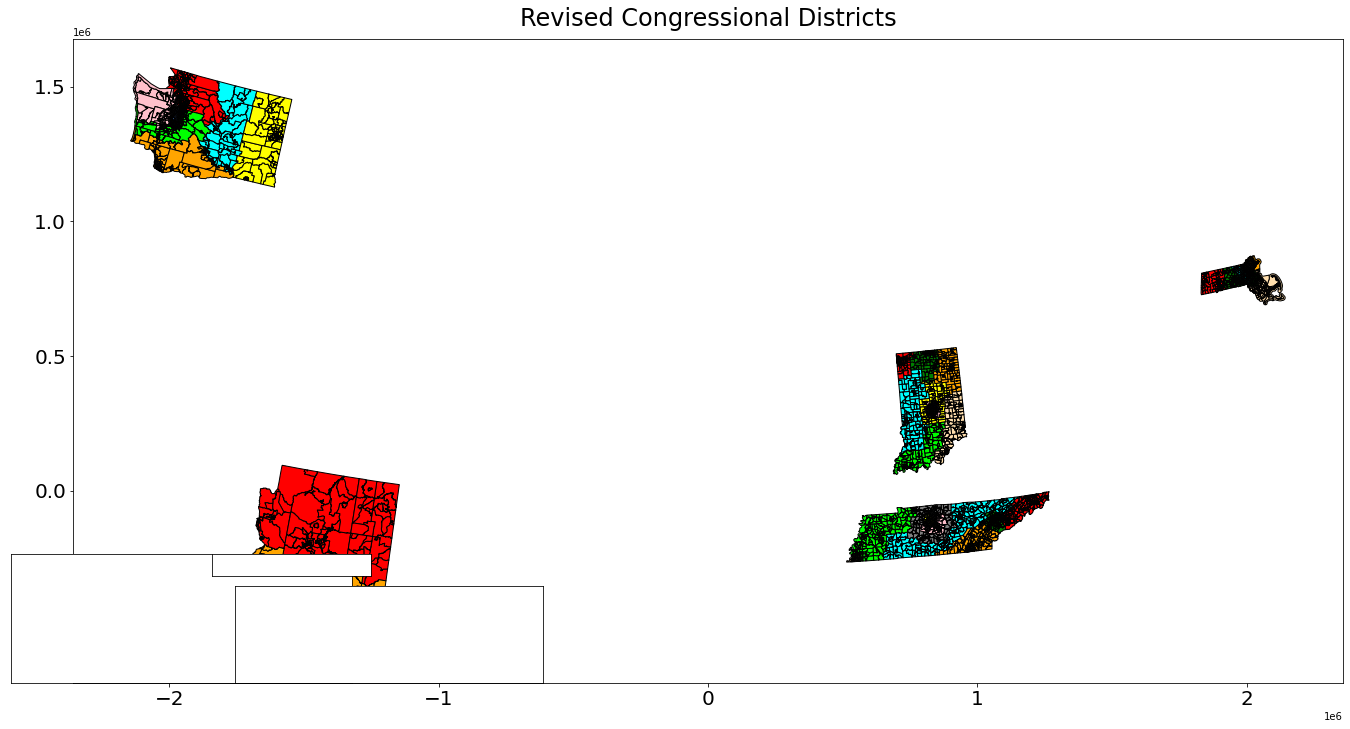

Done plotting and saving in 121 seconds!


In [23]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-1-to-7.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [24]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-9-10.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 8,566 in 0 minutes 0 seconds!


TOTAL TIME: 14 minutes 46 seconds!


# VIRGINIA

In [25]:
# s = time.time()

# this_state = 'VA'
# examine_duplicates = True

# nDistricts = these_states_dict[this_state]['seats_new']
# state_target = these_states_dict[this_state]['target']

# #print('getting from backup...')
# tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

# county_mapper_df = pandas.DataFrame(data=[    
# #['Whatcom County',1],  

# ], columns=['COUNTY_NAME', 'new_district_by_county'])
# county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

# place_mapper_df = pandas.DataFrame(data=[
# # ['Arlington',8], 
# #     ['Alexandria',8],
# #     ['Great Falls',8],
# #     ["Bailey's Crossroads",8], 
# #     ['McLean',8], 
# #     ['Seven Corners',8], 
# #     ['Lake Barcroft',8], 
# #     ['Falls Church',8], 
# #     ['West Falls Church',8],     
# #     ['Pimmit Hills',8], 
# #     ['Idylwood',8], 
# #     ['Tysons',8], 
# #     ['Dunn Loring',8], 
# #     ['Vienna',8],
# #     ['Merrifield',8], 
# #     ['Wolf Trap',8],
# #     ['Huntington',8],
# #     ['Belle Haven',8],
# #     ['Rose Hill',8],
# #     ['Groveton',8],
# #     ['Fort Hunt',8],
# #     ['Woodlawn',8],
# #     ['Mount Vernon',8],
    
    
    
# # ['Lincolnia',11], 
# #    ['Annandale',11],
# #    ['Hayfield',11],
# #     ['Springfield',11], 
# #     ['North Springfield',11], 
# #    ['Woodburn',11], 
# #    ['Ravensworth',11], 
# #    ['Kings Park',11], 
# #    ['Wakefield',11],
# #    ['Mantua',11], 
# #    ['Franconia',11], 
# #    ['Kingstowne',11],
# #     ['Fort Belvoir',11], 
# #     ['Newington',11], 
# #     ['Newington Forest',11], 
# #     ['West Springfield',11], 
# #     ['Burke',11], 
# #     ['Burke Centre',11], 
# #     ['Kings Park West',11], 
# #     ['Long Branch',11],
# #     ['Fairfax',11], 
# #     ['Fairfax Station',11], 
# #     ['Braddock',11], 
# #     ['George Mason',11], 
# #     ['Fair Oaks',11], 
# #     ['Oakton',11], 
# #     ['Difficult Run',11], 
# #     ['Reston',11], 
# #     ['Great Falls Crossing',11],   
# #     ['Lorton',11], 
# #     ['Laurel Hill',11], 
# #     ['Crosspointe',11], 
# #     ['South Run',11], 
# #     ['Clifton',11], 
# #     ['Union Mill',11], 
# #     ['Centreville',11], 
# #     ['Fair Lakes',11],
# #     ['Navy',11], 
# #     ['Greenbriar',11], 
# #     ['Chantilly',11], 
# #     ['Sully Square',11], 
# #     ['Franklin Farm',11], 
# #     ['Floris',11], 
# #     ['McNair',11], 
# #     ['Hutchison',11], 
# #     ['Herndon',11], 
# #     ['Dranesville',11],

    
    
# ['Virginia Beach',3], 
#     ['Norfolk',3], 
# #    ['Portsmouth',3], 
#     #['Chesapeake',3],
# ], columns=['NAME', 'new_district_by_place'])


# #print('Assigning districts by county...')
# tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


# print('Assigning districts by place...')
# place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


# print('Accounting for known duplicate places...')
# keepers = {}
# keepers['Belle Haven'] = {'GEOID': '1600000US5105928', 'description': 'overlaps 2 tracts containing 6,851 people'}
# keepers['Rose Hill'] = {'GEOID': '1600000US5168880', 'description': 'overlaps 6 tracts containing 22,940 people'}
# keepers['Woodlawn'] = {'GEOID': '1600000US5187410', 'description': 'overlaps 4 tracts containing 20,859 people'}
# keepers['Wakefield'] = {'GEOID': '1600000US5182371', 'description': 'overlaps 3 tracts containing 14,689 people'}


# for k,v in keepers.items():
#     print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
#     place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

# print('\n')
# print('checking for additional duplicate nanes...')
# duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
# for this_place in duplicate_place_names:
#     print('Examining {0:}...'.format(this_place))
    
#     for ix, thisrow in place_gdf[
#         (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (place_gdf['NAME'] == this_place)
#     ].to_crs(equal_area_crs).iterrows():
#         included_tracts = []
#         place_area = thisrow.geometry.area
#         print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
#         for jx, thatrow in county_gdf[
#             (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#             & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#         ].to_crs(equal_area_crs).iterrows():
#             if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
#                 print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
#                 for kx, otherrow in tract_gdf[
#                     #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#                     (tract_gdf['STUSAB'] == this_state)
#                     & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
#                     & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
#                 ].to_crs(equal_area_crs).iterrows():
#                     tract_area = otherrow.geometry.area
#                     overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
#                     pct_overlap = overlap_area / tract_area
#                     if (pct_overlap >= desired_pct_area_overlap):
#                         print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
#                         included_tracts.append(kx)
#         print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
#         print('-------------------------------------')
#         print('\n')
        
# print('\n')
# for i in range(1, nDistricts+1):
#     print('Looking for tracts related to places in District {0:.0f}...'.format(i))
#     tracts_here = []
#     this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
#     tracts_within = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.within(this_district_places_geo))
#     ].index.tolist()
#     if (len(tracts_within) > 0):
#         print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
#     tracts_here += tracts_within
    
#     intersecting_tracts = tract_gdf[
#         (tract_gdf['STUSAB'] == this_state) 
#         & (tract_gdf['new_district'].isnull()) 
#         & (tract_gdf.geometry.intersects(this_district_places_geo))
#         & ~(tract_gdf.index.isin(tracts_within))
#     ].index.tolist()
#     if (len(intersecting_tracts) > 0):
#         print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
#     cnt = 0
#     for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
#         cnt += 1
#         if (np.mod(cnt,50) == 1):            
#             print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
#         tract_area_sq_deg = thisrow.geometry.area
#         overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
#         overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
#         if (overlap_pct >= desired_pct_area_overlap):
#             tracts_here.append(ix)
#             #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

#     tract_gdf.loc[tracts_here, 'new_district'] = i

# print('Assigning districts by tract number...')
# tract_gdf.loc[['1400000US51059415401', '1400000US51059421500'], 'new_district'] = 8    # N of Mount Vernon

# tract_gdf.loc[['1400000US51059416200', '1400000US51059416300', '1400000US51059440504', '1400000US51059491101', '1400000US51059492100', '1400000US51059492201', '1400000US51059492500', '1400000US51059980100', '1400000US51059980200'], 'new_district'] = 11    # Rest of Fairfax County


# Che-201.0: 1400000US51550020100
# 	Che-202.0: 1400000US51550020200
# 	Che-203.0: 1400000US51550020300
# 	Che-204.0: 1400000US51550020400
	
# 	Che-208.08: 1400000US51550020808
# 	Che-208.09: 1400000US51550020809
# tract_gdf.loc[['1400000US51550020001', '1400000US51550020002', '1400000US51550020003'], 'new_district'] = 3    # N part of city of Chesapeake



# # print('All the rest are district 4...')
# # tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 4


# # print('Except ocean tracts, figuring...')
# # tract_gdf.loc[['1400000US53033990100'], 'new_district'] = 10    # Oceany part of King County



# e = time.time()
# g += (e-s)

# #print('\n')
# print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
# print('\n')


# # print('saving outfile...')
# # tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

# nDone = 0
# total_difference = 0
# total_sum = 0
# for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         nDone += 1
#         total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
#         total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
#         #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

        
# # def millions(x, pos):
# #     'The two args are the value and tick position'
# #     return '%1.3fe6' % (x * 1e-6)

# e = time.time()
# g += (e-s)


# # print('\n')
# # print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
# print('Done!')




In [26]:
# s = time.time()
# this_state = 'VA'

# show_water = False
# label_tracts = True

# show_counties = True
# label_counties = False

# show_places = True
# label_places = False

# print_ready = False
# assign_to_district = 11

# the_label_size = 20
# the_annotation_size = 18
# #the_annotation_size_big = 28
# the_line_width = .5
# the_line_width_wide = 4
# the_legend_size = 18
# the_title_size = 28

# bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]


# ### DC Area
# # xlimits = [1.56e6,1.64e6]
# # ylimits = [270000,340000]

# #### Alexandria/Arlington
# # xlimits = [1.58e6,1.62e6]
# # ylimits = [295000,335000]

# ## # Virginia Beach area
# # xlimits = [1.7e6,1.765e6]
# # ylimits = [70000,140000]


# ## # Chesapeake
# xlimits = [1.724e6,1.748e6]
# ylimits = [78000,110000]


# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} km'.format(xspan / 1000))
# print('yspan = {0:,.2f} km'.format(yspan / 1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')


# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')

# print('plotting tracts...')
# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# tract_gdf[(tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)


# if (show_counties):
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width)

# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) > 0):
#         counties_to_label = bounds_counties
#     else:
#         counties_to_label = county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]]['NAME'].tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (county_gdf['NAME'].isin(counties_to_label))
# #         & ( 
# #             ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #             & ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) <= xlimits[1]))
# #         )        
#     ].to_crs(main_map_crs).iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAMELSAD'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='black', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size)


# if (show_places):
#     print('plotting places...')
#     place_gdf.to_crs(main_map_crs).plot(ax=ax, edgecolor='purple', lw=the_line_width_wide, color='none')
    
# if (label_places):
#     print('\tlabeling places...')
#     for ix, thisrow in geopandas.overlay(
#         place_gdf.reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (thisrow['NAME'] not in ['Tanglewilde']):
#                 annotator = thisrow['NAME'].replace(' ', '\n')
#                 centerpoint = thisrow.geometry.centroid.coords[0]
#                 ax.annotate(annotator, centerpoint, color='purple', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.to_crs(main_map_crs).plot(ax=ax, color='blue')

# if (label_tracts):
#     print('\tlabeling tracts...')
#     for ix, thisrow in geopandas.overlay(
#         tract_gdf[
#             (tract_gdf['new_district'].isnull())
# #            (tract_gdf['new_district'] == 11)
#         ].reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             print('\t{0:}-{1:}: {2:}'.format(thisrow['COUNTY_NAME'][0:3], thisrow['census_tract'], ix))
#             annotator = '{0:}\n({1:,.0f})'.format(thisrow['census_tract'], thisrow['POP100'])
#             centerpoint = thisrow.geometry.centroid.coords[0]
#             ax.annotate(annotator, centerpoint, color='black', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))
    
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# ax.tick_params(axis='both', labelsize=20, labelbottom=True, labeltop=True, labelleft=True, labelright=True)

# # nticks = 10
# # ax.set_xticks(np.arange(xlimits[0], xlimits[1], (xlimits[1]-xlimits[0])/nticks))
# # ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.set_yticks(np.arange(ylimits[0], ylimits[1], (ylimits[1]-ylimits[0])/nticks))
# # ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size, length=10, width=4, left=True, right=True)
# # ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size, length=10, width=4, top=True, bottom=True)

# #ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')



# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:    
#     plt.title('New Congressional Districts', fontsize=the_title_size)

# print('\n')    
# for i in range(1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))
# plt.show()





In [27]:

# #### WASHINGTON #####

# ### Central Pierce County
# # xlimits = [-2.01e6, -1.96e6]
# # ylimits = [1.33e6,1.37e6]

### South King County (District 7/10 border)
# xlimits = [-1.98e6, -1.956e6]
# ylimits = [1.366e6, 1.386e6]


### Central Pierce County
# xlimits = [-2.01e6, -1.96e6]
# ylimits = [1.33e6,1.37e6]

### South King County (District 7/10 border)
# xlimits = [-1.98e6, -1.956e6]
# ylimits = [1.366e6, 1.386e6]

### East of Lake Washington
# xlimits = [-1.965e6, -1.94e6]
# ylimits = [1.385e6,1.42e6]

### Everett area
# xlimits = [-1.97e6,-1.94e6]
# ylimits = [1.42e6, 1.45e6]


### East Pierce / North Thurston Counties
# xlimits = [-2.05e6,-1.98e6]
# ylimits = [1.34e6,1.39e6]


### Central Pierce County
# xlimits = [-2.01e6, -1.96e6]
# ylimits = [1.33e6,1.37e6]

### South King County (District 7/10 border)
# xlimits = [-1.98e6, -1.956e6]
# ylimits = [1.366e6, 1.386e6]

### East of Lake Washington
# xlimits = [-1.965e6, -1.94e6]
# ylimits = [1.385e6,1.42e6]

### Everett area
# xlimits = [-1.97e6,-1.94e6]
# ylimits = [1.42e6, 1.45e6]

### Central Pierce County closeup
# xlimits = [-1.995e6, -1.96e6]
# ylimits = [1.345e6,1.36e6]

### East Pierce / North Thurston Counties
# xlimits = [-2.05e6,-1.98e6]
# ylimits = [1.34e6,1.39e6]

### W Lewis County
# xlimits = [-2.075e6,-2.025e6]
# ylimits = [1.28e6,1.34e6]

### Yakima
# xlimits = [-1.88e6,-1.84e6]
# ylimits = [1.24e6,1.28e6]


In [28]:
# #county_gdf[county_gdf['STATEFP'] == 51][['NAME','NAMELSAD']].sort_values(by='NAMELSAD')[0:20]
# #county_gdf[county_gdf['STATEFP'] == 51].groupby('NAME').size().sort_values(ascending=False)

# bounds_counties_lsad = ['Arlington County', 'Fairfax County', 'Fairfax city', 'Alexandria city', 'Falls Church city']

# unary_union(county_gdf[(county_gdf['STATEFP'] == 51) & (county_gdf['NAMELSAD'].isin(bounds_counties_lsad))].geometry.tolist())

# #[unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties_lsad))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAMELSAD'].isin(bounds_counties_lsad))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]